# Import

In [ ]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Import : by GitHub

You can try this code in Colab by this method.  


In [ ]:
!git clone https://github.com/KanghwaSisters/24_2_mainSession.git 

In [ ]:
import os
os.chdir('/content/24_2_mainSession/4주차/env') 

In [ ]:
! python GridWorldEnvironment.py # py file 실행

In [ ]:
from GridWorldEnvironment import GridWorldEnvironment

## 04 SARSA
---

### Agent_SA

In [ ]:
class SARSAAgent:
    def __init__(self, action_space):
        # 행동에 관한 파라미터
        self.action_space = action_space
        self.num_actions = len(action_space)

        # 학습에 관련된 파라미터
        self.step_size = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01

        # 0을 초깃값으로 하는 큐함수 테이블 생성
        self.q_table = defaultdict(lambda: np.zeros(self.num_actions).tolist())

    def update_q_table(self, state, action_idx, reward, next_state, next_action_idx):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # idx로 사용하기 위해 (n,n) 좌표로 표현된 state를 문자열로 만든다.
        state, next_state = str(state), str(next_state)

        # 시간차 제어로 큐테이블을 업데이트한다.
        current_q = self.q_table[state][action_idx]
        next_q = self.q_table[next_state][next_action_idx]
        td = reward + self.discount_factor * next_q - current_q
        new_q = current_q + self.step_size * td
        self.q_table[state][action_idx] = new_q

    def get_action(self, state):
        '''
        입실론 탐욕 정책을 통해 행동을 반환한다.
        '''
        # 0을 초깃값으로 하는 큐함수 테이블 생성
        if np.random.rand() < self.epsilon:
            # 무작위 행동 수행
            action_idx = np.random.choice(range(self.num_actions))
        else:
            # 큐 함수에 따른 행동
            state = str(state)
            q_list = self.q_table[state]
            action_idx = self.argmax(q_list)

        return action_idx

    def argmax(self, q_list):
        '''
        np.argmax를 사용하지 않고 별도의 매소드를 사용하는 이유
        Q-table에 값이 같은 action이 여러 개가 있다면,
        그중에서 랜덤으로 선택해야 하기 때문이다.
        '''
        max_value = np.amax(q_list)
        max_indices = np.where(q_list == max_value)[0]
        return np.random.choice(max_indices)


### main_SA

In [ ]:
# init value
env = GridWorldEnvironment(start_point=(0,0),
                           end_point=(4,4),
                           gridworld_size=(5,5))

agent = SARSAAgent(env.action_space)

EPISODES = 1000
RENDER_PROCESS = False
RENDER_END = False
total_moves = []

In [ ]:
# train code

for episode in range(EPISODES):
    # 게임 환경을 초기화
    state = env.reset()
    moves_cnt = 0
    # 현재 상태에서 행동을 선택한다.
    action_idx = agent.get_action(state)

    done = False

    while not done:
        if RENDER_PROCESS:
            env.render() # 이동을 출력하기

        # 취한 행동에 대한 next_state, reward, done을 환경이 제공한다.
        next_state, reward, done = env.step(action_idx)

        # 다음 상태에서 행동을 선택한다.
        next_action_idx = agent.get_action(next_state)

        # 큐함수를 업데이트한다.
        agent.update_q_table(state, action_idx, reward, next_state, next_action_idx)

        state = next_state
        action_idx = next_action_idx
        moves_cnt += 1

    total_moves.append(moves_cnt)

    if (episode+1) % 100 == 0:
        print(f"[Episode]: {episode+1}/{EPISODES} __ [Num of Moves mean]:{np.mean(total_moves[episode-99:]):.1f} __ [Epsilon]: {agent.epsilon:.3f}")

    if RENDER_END:
        env.render()


[Episode]: 100/1000 __ [Num of Moves mean]:20.9 __ [Epsilon]: 0.123
[Episode]: 200/1000 __ [Num of Moves mean]:8.8 __ [Epsilon]: 0.051
[Episode]: 300/1000 __ [Num of Moves mean]:8.4 __ [Epsilon]: 0.022
[Episode]: 400/1000 __ [Num of Moves mean]:8.2 __ [Epsilon]: 0.010
[Episode]: 500/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 600/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 700/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 800/1000 __ [Num of Moves mean]:8.0 __ [Epsilon]: 0.010
[Episode]: 900/1000 __ [Num of Moves mean]:8.2 __ [Epsilon]: 0.010
[Episode]: 1000/1000 __ [Num of Moves mean]:8.0 __ [Epsilon]: 0.010


In [ ]:
# 마지막 학습 상황을 재현한다.
env.render()

S X . . . 
. X . . . 
. X X . . 
. . X X X 
. . . . A 



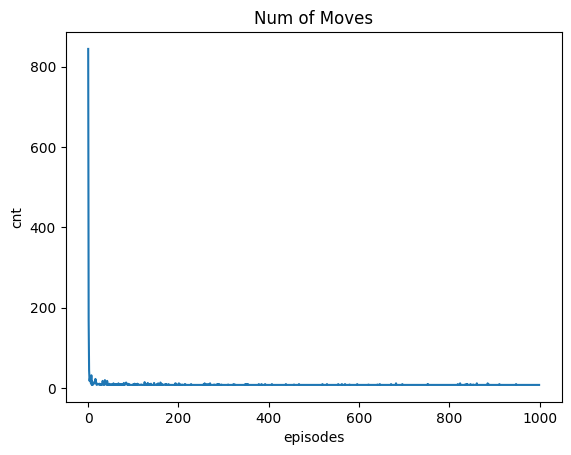

In [ ]:
# 1000 에피소드에서 에이전트의 이동 횟수를 시각화
plt.plot(total_moves)
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()

## 05 Q-Learning
---

### Agent_QL

In [ ]:
class QlearningAgent:
    def __init__(self, action_space):
        # 행동에 관한 파라미터
        self.action_space = action_space
        self.num_actions = len(action_space)

        # 학습에 관련된 파라미터
        self.step_size = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01

        # 0을 초깃값으로 하는 큐함수 테이블 생성
        self.q_table = defaultdict(lambda: np.zeros(self.num_actions).tolist())

    def update_q_table(self, state, action_idx, reward, next_state):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # idx로 사용하기 위해 (n,n) 좌표로 표현된 state를 문자열로 만든다.
        state, next_state = str(state), str(next_state)

        q_1 = self.q_table[state][action_idx]

        # 벨만 최적 방정식을 사용한 큐함수 업데이트
        q_2 = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action_idx] += self.step_size * (q_2 - q_1)

    def get_action(self, state):
        '''
        입실론 탐욕 정책(ε-greedy policy)을 통해 행동을 반환한다.
        '''
        # 0을 초깃값으로 하는 큐함수 테이블 생성
        if np.random.rand() < self.epsilon:
            # 무작위 행동 수행
            action_idx = np.random.choice(range(self.num_actions))
        else:
            # 큐 함수에 따른 행동
            state = str(state)
            q_list = self.q_table[state]
            action_idx = self.argmax(q_list)

        return action_idx

    def argmax(self, q_list):
        '''
        np.argmax를 사용하지 않고 별도의 매소드를 사용하는 이유
        Q-table에 값이 같은 action이 여러 개가 있다면,
        그중에서 랜덤으로 선택해야 하기 때문이다.
        '''
        max_value = np.amax(q_list)
        max_indices = np.where(q_list == max_value)[0]

        return random.choice(max_indices)


### main_QL

In [ ]:
# init value
env = GridWorldEnvironment(start_point=(0,0),
                           end_point=(4,4),
                           gridworld_size=(5,5))

agent = QlearningAgent(env.action_space)

EPISODES = 1000
RENDER_PROCESS = False
RENDER_END = False
total_moves = []

In [ ]:
# train code

for episode in range(EPISODES):
    # 게임 환경을 초기화
    state = env.reset()
    moves_cnt = 0

    done = False

    while not done:
        if RENDER_PROCESS:
            env.render() # 이동을 출력하기

        # 현재 상태에 대한 행동 선택
        action_idx = agent.get_action(state)
        # 취한 행동에 대한 next_state, reward, done을 환경이 제공한다.
        next_state, reward, done = env.step(action_idx)

        # 큐함수를 업데이트한다.
        agent.update_q_table(state, action_idx, reward, next_state)

        state = next_state
        moves_cnt += 1

    total_moves.append(moves_cnt)

    if (episode+1) % 100 == 0:
        print(f"[Episode]: {episode+1}/{EPISODES} __ [Num of Moves mean]:{np.mean(total_moves[episode-99:]):.1f} __ [Epsilon]: {agent.epsilon:.3f}")

    if RENDER_END:
        env.render()


[Episode]: 100/1000 __ [Num of Moves mean]:16.6 __ [Epsilon]: 0.189
[Episode]: 200/1000 __ [Num of Moves mean]:8.9 __ [Epsilon]: 0.078
[Episode]: 300/1000 __ [Num of Moves mean]:8.2 __ [Epsilon]: 0.034
[Episode]: 400/1000 __ [Num of Moves mean]:8.2 __ [Epsilon]: 0.015
[Episode]: 500/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 600/1000 __ [Num of Moves mean]:8.0 __ [Epsilon]: 0.010
[Episode]: 700/1000 __ [Num of Moves mean]:8.1 __ [Epsilon]: 0.010
[Episode]: 800/1000 __ [Num of Moves mean]:8.0 __ [Epsilon]: 0.010
[Episode]: 900/1000 __ [Num of Moves mean]:8.0 __ [Epsilon]: 0.010
[Episode]: 1000/1000 __ [Num of Moves mean]:8.0 __ [Epsilon]: 0.010


In [ ]:
# 마지막 학습 상황을 재현한다.
env.render()

S . . . . 
X . . . . 
X . . . . 
X X X X X 
. . . . A 



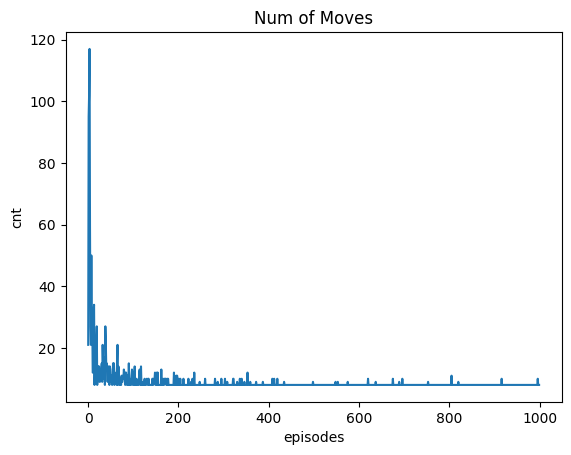

In [ ]:
# 1000 에피소드에서 에이전트의 이동 횟수를 시각화
plt.plot(total_moves)
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()